In [20]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [21]:
#Load dataset
categories = ['sci.med', 'comp.graphics']
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({'text': data.data, 'target': data.target})

In [22]:
#Clean raw text (remove symbols, lowercase, remove duplicates)
stop_words = text.ENGLISH_STOP_WORDS

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = [word for word in text.split() if word not in stop_words]
    unique_tokens = list(dict.fromkeys(tokens))  # remove duplicates while preserving order
    return ' '.join(unique_tokens)

df['clean'] = df['text'].apply(clean_text)

X = df['clean']
y = df['target']

In [23]:
#Split the data into training and testing sets(80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
)

In [24]:
#Define configurations
vectorizers = {
    'Count': CountVectorizer(),
    'TFIDF': TfidfVectorizer()
}

models = {
    'Multinomial': MultinomialNB,
    'Bernoulli': BernoulliNB
}

alphas = [0.1, 0.5, 1, 5, 10]
results = []

In [25]:
#Train and evaluate all combinations
for vec_name, vec in vectorizers.items():
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)

    for model_name, model_class in models.items():
        for alpha in alphas:
            start = time.time()
            model = model_class(alpha=alpha)
            model.fit(X_train_vec, y_train)
            end = time.time()

            y_pred = model.predict(X_test_vec)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
            cm = confusion_matrix(y_test, y_pred)

            results.append({
                'Vectorizer': vec_name,
                'Model': model_name,
                'Alpha': alpha,
                'Accuracy': acc,
                'F1': f1,
                'TrainTime': end - start,
                'ConfusionMatrix': cm,
                'ErrorRate': 1 - acc
            })

In [26]:
#Create DataFrame and sort
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

In [27]:
#Display top results
print("=== Top 10 Model Configurations ===")
print(results_df_sorted.head(10))

=== Top 10 Model Configurations ===
   Vectorizer        Model  Alpha  Accuracy        F1  TrainTime  \
0       Count  Multinomial    0.1  0.959288  0.959287        0.0   
5       Count    Bernoulli    0.1  0.956743  0.956607        0.0   
15      TFIDF    Bernoulli    0.1  0.956743  0.956607        0.0   
10      TFIDF  Multinomial    0.1  0.956743  0.956742        0.0   
1       Count  Multinomial    0.5  0.951654  0.951654        0.0   
11      TFIDF  Multinomial    0.5  0.951654  0.951649        0.0   
2       Count  Multinomial    1.0  0.951654  0.951654        0.0   
12      TFIDF  Multinomial    1.0  0.949109  0.949106        0.0   
3       Count  Multinomial    5.0  0.941476  0.941462        0.0   
6       Count    Bernoulli    0.5  0.938931  0.938642        0.0   

          ConfusionMatrix  ErrorRate  
0   [[188, 11], [5, 189]]   0.040712  
5   [[199, 0], [17, 177]]   0.043257  
15  [[199, 0], [17, 177]]   0.043257  
10  [[189, 10], [7, 187]]   0.043257  
1   [[187, 12], [7, 

In [28]:
#Recommending the best method
best = results_df_sorted.iloc[0]
print("\n✅ Recommended Method:")
print("the best-performing configuration is as follows:\n")
print(f"Model: {best['Model']}")
print(f"Feature Extraction Method: {best['Vectorizer']}")
print(f"Alpha: {best['Alpha']}")
print(f"\nReason for Selection:")
print(f"This configuration achieved the highest accuracy ({best['Accuracy']:.4f}) and F1 score ({best['F1']:.4f})")
print("among all tested models. It effectively distinguished between the two categories with balanced performance.")


✅ Recommended Method:
the best-performing configuration is as follows:

Model: Multinomial
Feature Extraction Method: Count
Alpha: 0.1

Reason for Selection:
This configuration achieved the highest accuracy (0.9593) and F1 score (0.9593)
among all tested models. It effectively distinguished between the two categories with balanced performance.


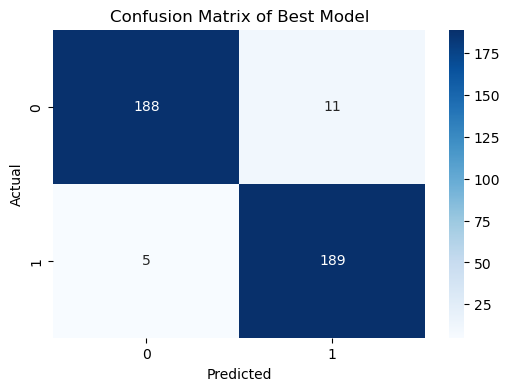

In [29]:
#Plot confusion matrix for best model
plt.figure(figsize=(6, 4))
sns.heatmap(best['ConfusionMatrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


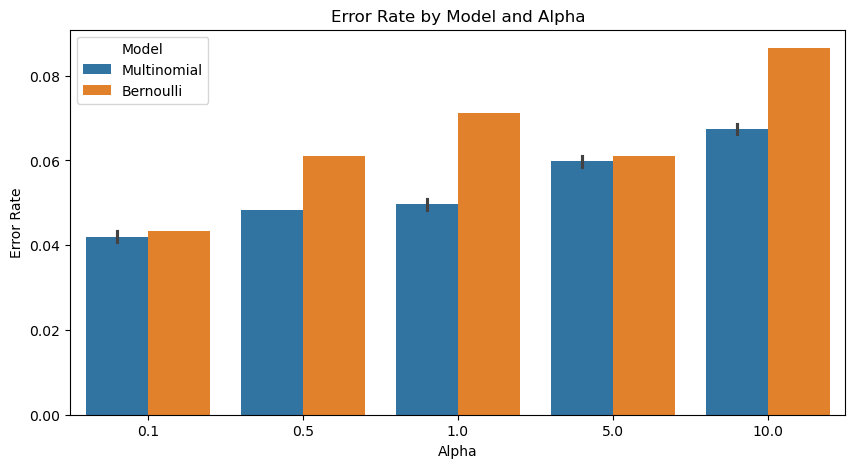

In [30]:
#Plot error rates across all models
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df_sorted, x='Alpha', y='ErrorRate', hue='Model')
plt.title('Error Rate by Model and Alpha')
plt.ylabel('Error Rate')
plt.xlabel('Alpha')
plt.legend(title='Model')
plt.show()

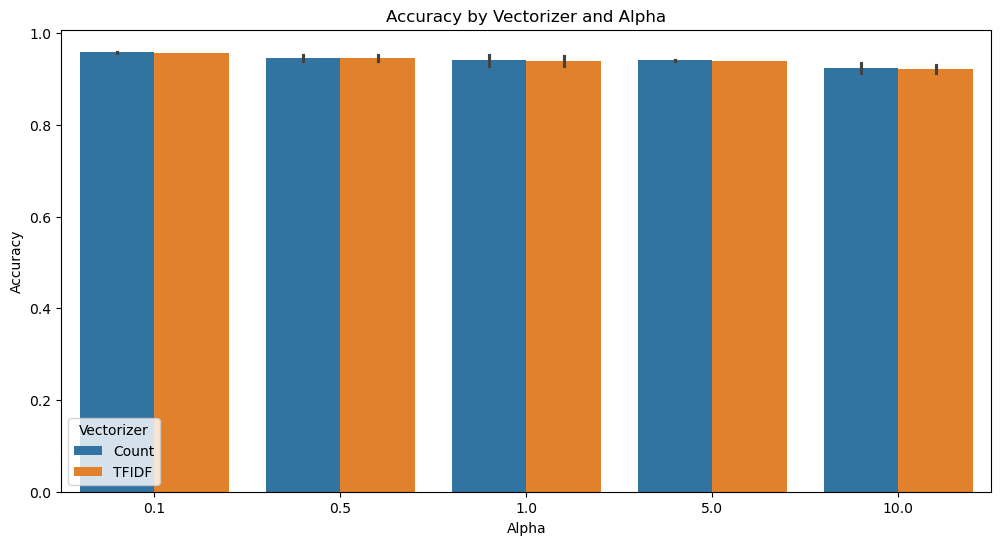

In [31]:
#Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df_sorted, x='Alpha', y='Accuracy', hue='Vectorizer')
plt.title('Accuracy by Vectorizer and Alpha')
plt.ylabel('Accuracy')
plt.xlabel('Alpha')
plt.legend(title='Vectorizer')
plt.show()